In [3]:
import bpy
from math import sqrt
import numpy as np

# -----------------------------------------------------------------------------
# Settings
name = 'Icosomething'
scale = 1
subdiv = 4

# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# Add Object to Scene


middle_point_cache = {}

def vertex(x, y, z): 
    length = sqrt(x**2 + y**2 + z**2) 
    return [(i * scale) / length for i in (x,y,z)]

def middle_point(point_1, point_2): 
    smaller_index = min(point_1, point_2) 
    greater_index = max(point_1, point_2) 
    key = '{0}-{1}'.format(smaller_index, greater_index) 
    if key in middle_point_cache: 
        return middle_point_cache[key] 
    vert_1 = verts[point_1]
    vert_2 = verts[point_2]
    middle = [sum(i)/2 for i in zip(vert_1, vert_2)]
    verts.append(vertex(*middle))
    index = len(verts) - 1 
    middle_point_cache[key] = index 
    return index


#------------------------------------------------------

PHI = (1 + sqrt(5)) / 2 
verts = [ vertex(-1, PHI, 0), vertex( 1, PHI, 0), vertex(-1, -PHI, 0), vertex( 1, -PHI, 0), vertex(0, -1, PHI), vertex(0, 1, PHI), vertex(0, -1, -PHI), vertex(0, 1, -PHI), vertex( PHI, 0, -1), vertex( PHI, 0, 1), vertex(-PHI, 0, -1), vertex(-PHI, 0, 1), ] 
faces = [[0, 11, 5], [0, 5, 1], [0, 1, 7], [0, 7, 10], [0, 10, 11],[1, 5, 9], [5, 11, 4], [11, 10, 2], [10, 7, 6], [7, 1, 8],[3, 9, 4], [3, 4, 2], [3, 2, 6], [3, 6, 8], [3, 8, 9],[4, 9, 5], [2, 4, 11], [6, 2, 10], [8, 6, 7], [9, 8, 1]]


# Subdivisions # 
for i in range(subdiv): 
    faces_subdiv = [] 
    for tri in faces: 
        v1 = middle_point(tri[0], tri[1]) 
        v2 = middle_point(tri[1], tri[2]) 
        v3 = middle_point(tri[2], tri[0]) 
        faces_subdiv.append([tri[0], v1, v3]) 
        faces_subdiv.append([tri[1], v2, v1]) 
        faces_subdiv.append([tri[2], v3, v2]) 
        faces_subdiv.append([v1, v2, v3]) 
    faces = faces_subdiv
    
mesh = bpy.data.meshes.new(name)
mesh.from_pydata(verts, [], faces)

#obj = bpy.data.objects.new(name, mesh)
#bpy.context.scene.collection.objects.link(obj)

#bpy.context.view_layer.objects.active = obj
#obj.select = True
    
#bpy.ops.object.shade_smooth()
#for face in mesh.polygons: 
#    face.use_smooth = True

In [4]:
n = len(verts)
lap = 0*np.diag(np.ones(n,))
for tri in faces:
    lap[tri[0]][tri[1]] = 1
    lap[tri[1]][tri[0]] = 1
    lap[tri[0]][tri[2]] = 1
    lap[tri[2]][tri[0]] = 1
    lap[tri[1]][tri[2]] = 1
    lap[tri[2]][tri[1]] = 1

In [5]:
deg = np.sum(lap, axis=0)
lap = np.diag(deg) - lap
#lap_norm = np.diag(np.sqrt(deg)**(-1))*lap*np.diag(np.sqrt(deg)**(-1))

In [6]:
import scipy.sparse.linalg
result = np.linalg.eigh(lap)

In [7]:
import matplotlib.pyplot as plt

plt.plot(np.arange(2562),result[0])

In [43]:
A1 = 0.05*(9-0.0**2*np.array(verts)[:,2]**2) #2.9
A2 = -(3+2.9*np.array(verts)[:,2])*0 #0.02

In [44]:
H = 1/2*(A1[:,np.newaxis]*lap+lap*A1[np.newaxis,:])+np.diag(A2)*lap

In [45]:
resultH = np.linalg.eigh(H)

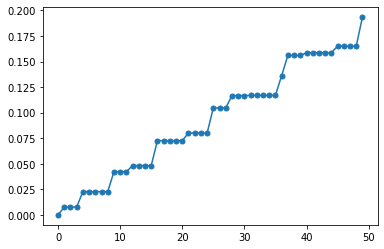

In [46]:
plt.plot(np.arange(50),resultH[0][:50], markersize=5, marker="o")

In [47]:
#theta = np.minimum(np.maximum(np.arccos(np.array(verts)[:,2]),1e-6),np.pi-1e-6)
#phi = np.minimum(np.maximum(np.arctan2(np.array(verts)[:,0],np.array(verts)[:,1]),1e-6),2*np.pi-1e-6)

In [48]:
import scipy.interpolate

#scipy.interpolate.SmoothSphereBivariateSpline(theta,phi,np.ones(2562,), w=resultH[1][1], eps=1e-2)
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

verts = np.array(verts)

interp = scipy.interpolate.Rbf(verts[:,0], verts[:,1], verts[:,2], resultH[1][:,10], function='thin_plate')

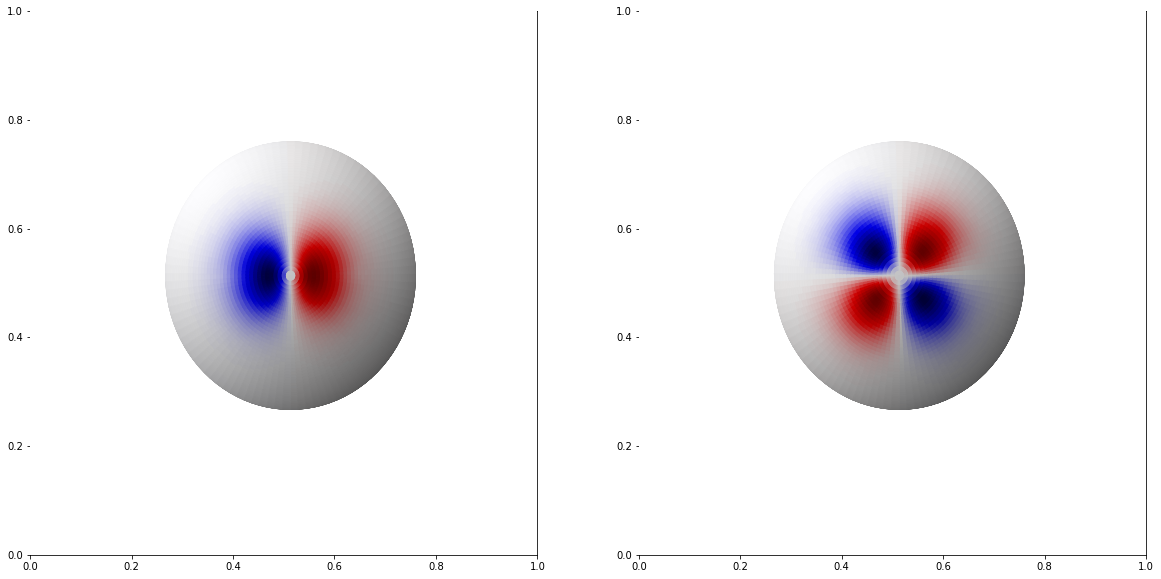

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm
import matplotlib.cm as cm

phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2*np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

#index = [1,5,10,20,100,200,1000,2000]
index = [1,5]
leng = len(index)

fig, axs = plt.subplots(1,leng,figsize=(20,10))

for i in range(leng):
    interp = scipy.interpolate.Rbf(verts[:,0], verts[:,1], verts[:,2], resultH[1][:,index[i]], function='thin_plate')
    # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
    fcolors = interp(x,y,z)
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors - fmin)/(fmax - fmin)

    # Set the aspect ratio to 1 so our sphere looks spherical
    axs[i] = fig.add_subplot(1,leng,i+1, projection='3d')
    # Turn off the axis planes
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i]._axis3don = False
    axs[i].get_yaxis().set_visible(False)
    axs[i].axis('off')
    axs[i].view_init(elev=90, azim=0)
    axs[i].plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.seismic(fcolors))

plt.savefig('./modes.jpg')

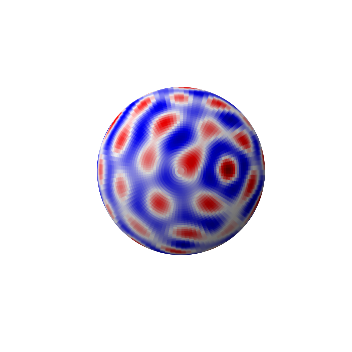

In [61]:
fig = plt.figure(figsize=(5,5),tight_layout = {'pad': 0})
interp = scipy.interpolate.Rbf(verts[:,0], verts[:,1], verts[:,2], resultH[1][:,199], function='thin_plate')
# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = interp(x,y,z)
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

# Set the aspect ratio to 1 so our sphere looks spherical
ax = fig.add_subplot(111, projection='3d')
# Turn off the axis planes
ax.set_xticks([])
ax.set_yticks([])
ax._axis3don = False
ax.get_yaxis().set_visible(False)
ax.axis('off')
ax.view_init(elev=90, azim=0)
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.seismic(fcolors))

plt.savefig('./fig/mode_base_6.jpg',bbox_inches='tight', pad_inches = -1)